### Note: Please ensure that this notebook is run in the daq environment

#### Run this after the regular concatenation is done


Assumes one trigger per experiment for each headmounted mic

Assumes that the headmounted mic is started after cameras are started

In [14]:
import glob
import os
import tqdm
from collections import defaultdict
import re
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import pandas as pd
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import cv2
import matplotlib.pyplot as plt
import datetime
import scipy.signal as sps
import librosa
import xml.etree.ElementTree as ET
import warnings

In [ ]:
# Path to the nidaq data for a particular experiment
experiment_no = 474
trig_channels = [10,11] # headmount trigger channel
# trig_channels = [0,1] # headmount trigger channel
sr = 125000
# mic_sr = 200000
nidaq_folder = "D:/big_setup/experiment_{}/nidaq/".format(experiment_no)
video_folder = "D:/big_setup/experiment_{}/videos/".format(experiment_no)
neural_folder = "D:/big_setup/experiment_{}/neural/".format(experiment_no)
exp_folder = "D:/big_setup/experiment_{}/".format(experiment_no)
cam_mic_sync_concat_folder = "D:/big_setup/experiment_{}/concatenated_data_cam_mic_sync/".format(experiment_no)
timestamp_file = "D:/big_setup/experiment_{}/camera_timestamps.csv".format(experiment_no)
camera_fps = 30

#### Defining functions we need

In [16]:
# Function to load the neural data binary file
def load_wm(bin_file):
	"""
	Load .bin file from white matter electophysiology system.

	Parameters:
	filenme: str
		Path to .bin file

	Returns:
	sr: int
		Sampling rate of physiology experiment.
	data: 2-D array
		(n_channels, n_samples) numpy array.
	"""

	#parse filename to get number of channels 
	n_channels = int(bin_file.split('_')[-2][:-2])

	print('Loading data')
	#load in binary data
	_data = np.fromfile(bin_file,'int16', offset=8)

	#reshape data to (n_samples, n_samples) and scale values to MICROVOLTS
	data = _data.reshape(-1,n_channels)*6.25e3/3276800 # added two zeros for headmounted mics to prevent hitting ceiling of int
	data = data.T.astype('float32') #transpose and convert back to int 16
	
	#parse filename to get sampling rate
	sr = int(bin_file.split('_')[-1][:-7])

	
	return sr, data[0]



In [17]:
# Functions to sort file names correctly
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

#### Finding the trigger

In [18]:
# Getting all indices in trigger channels
trig_files = []
for channel in trig_channels:
    channel_str = "%02d"%(channel)
    trig_files.append(glob.glob(cam_mic_sync_concat_folder+f"channel_{channel_str}_file_*.wav"))
    trig_files[-1].sort(key=natural_keys)

In [19]:
# Storing the index and detected samples for each trig channel
mic_trigger_info = {}
for channel in trig_channels:
    mic_trigger_info[channel] = {"rising_edges":np.array([],dtype=np.int64),"file_no":[]}

print("Getting the rising edges in the headmount trig signal")
for files in trig_files:
    concat_file_lengths = []
    for file in files:
        sampling_rate,ch = wavfile.read(file)
        concat_file_lengths.append(len(ch))
        file_no = int(file.split("_")[-1].split(".")[0])
        channel = int(file.split("_")[-3])
        
        # Getting all the rising edges in the trig indices channels
        threshold_r_low = 0.9 # To detect all rising edges within the threshold
        threshold_r_high = 9

        temp_r = []

        diff = ch[1:]-ch[0:-1]
        temp_r = np.where((diff>threshold_r_low) & (diff < threshold_r_high))[0] # The diff < 9 is to prevent detecting the stop nidaq record edge which reads a value 10


        if len(temp_r)>0:
            temp_r = temp_r.astype(np.int64)
            if len(temp_r>1):
                # Removing multiple detections of the same rising edge
                # trig_edge_freq = 10 # This is used to estimate when the next rising edge can be detected
                # window_samples = int((1/camera_sampling_rate)*sampling_rate) # Number of samples present in the window
                window_samples = 0.1 * sr

                prev_sample = temp_r[0]
                mic_trigger_info[channel]["rising_edges"] = np.append(mic_trigger_info[channel]["rising_edges"],prev_sample)
                mic_trigger_info[channel]["file_no"].append(file_no)
                for i in temp_r[1:]:
                    if not(abs(i - prev_sample) < window_samples):
                        mic_trigger_info[channel]["rising_edges"] = np.append(mic_trigger_info[channel]["rising_edges"],i)
                        mic_trigger_info[channel]["file_no"].append(file_no)
                    prev_sample = i
            else:
                mic_trigger_info[channel]["rising_edges"] = np.append(mic_trigger_info[channel]["rising_edges"],temp_r[0])
                mic_trigger_info[channel]["file_no"].append(file_no)
         

Getting the rising edges in the headmount trig signal


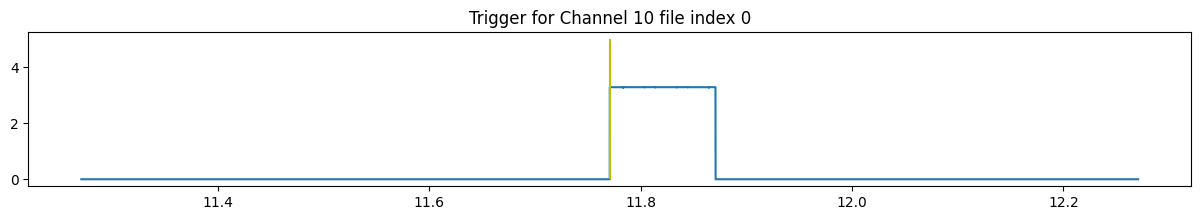

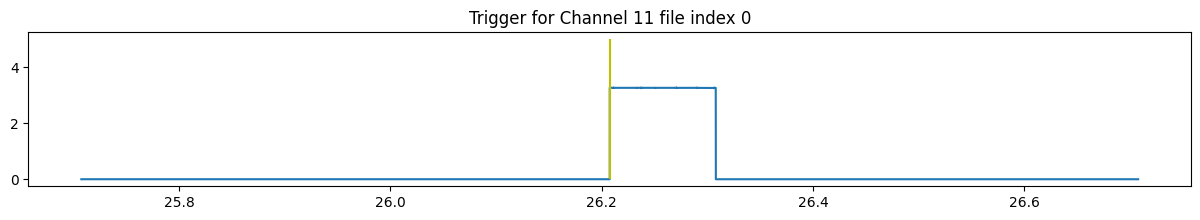

In [20]:
# Plotting the edges to verify
for channel in mic_trigger_info.keys():
    for rising_edge,file_no in zip(mic_trigger_info[channel]['rising_edges'],mic_trigger_info[channel]['file_no']):
        ch_str = "%02d"%(channel)
        file_no_str = "%03d"%(file_no)
        sampling_rate,ch = wavfile.read(cam_mic_sync_concat_folder+f"channel_{ch_str}_file_{file_no_str}.wav")

    
        fig = plt.figure(figsize=(15,2))
        plt.subplot(111)
        plt.title(f"Trigger for Channel {channel} file index {file_no}")

        time = np.array(range(len(ch)))/sampling_rate

        # getting the indices to plot for the start record clock channel
        first_sample = rising_edge - int(sampling_rate/2)
        last_sample = rising_edge + int(sampling_rate/2)


        plt.plot(time[first_sample:last_sample],ch[first_sample:last_sample],label = "Trigger")

        plt.vlines(time[rising_edge],0,5,'y', label = "Start Mic Record Point")

#### Note: Check that there is only one detection of the trigger in the channel

#### Formatting and storing the neural data

In [21]:
# Checking for the neural file names
neural_chs_names = glob.glob(exp_folder + "*.bin")
neural_chs_names.sort(key=natural_keys)
xml_names = glob.glob(exp_folder + "*.xml")
xml_names.sort(key=natural_keys)

In [22]:
neural_chs_names

['D:/big_setup/experiment_453\\HSW_2026_01_20__12_13_32__37min_03sec__mmx_adc_1ch_200000sps.bin',
 'D:/big_setup/experiment_453\\HSW_2026_01_20__12_13_46__36min_46sec__mmx_adc_1ch_200000sps.bin']

In [23]:
# logger info
logger_info = {}
times = []
logger_started_first = []
first_logger_time = ""
for idx,name in enumerate(xml_names):
    first_half = "_".join(name.split("__")[0].split("_")[-3:])
    second_half = "_".join(name.split("_")[-3:]).split(".")[0]
    name_check = "__".join([first_half,second_half])
    logger = 35 if "ID632E35" in name else 118
    if idx == 0:
        first_logger_time = name_check
        logger_started_first = logger
    else:
        if first_logger_time > name_check:
            first_logger_time = name_check
            logger_started_first = logger
    file = [i for i in neural_chs_names if name_check in i] 
    logger_info[logger] = file


In [24]:
# logger_started_first = 118

In [25]:
# Checking if both files have the same start time
if len(list(logger_info.values())[0]) > 1:
    warnings.warn("The start times in the file names are the same")
    # logger info
    logger_info = {}
    times = []
    logger_started_first = []
    first_logger_time = ""
    for idx,name in enumerate(xml_names):
        tree = ET.parse(name)
        root = tree.getroot()
        if root[2][9].tag == "PRECISE_DURATION_S": # change this if error raised
            recording_duration = int(root[2][9].text)
            min = recording_duration//60
            sec = recording_duration%60
            min_check = f"{min}min"
            sec_check = f"{sec}sec"
        else:
            raise Exception("the index of the xml file needs to be changed to get the precise duration")
        
        logger = 35 if "ID632E35" in name else 118
        file = [i for i in neural_chs_names if min_check in i and sec_check in i] 
        logger_info[logger] = file
    while True:
        logger_started_first = input("Enter which logger started first (35/118) pick any one and see if data is synced") 
        if logger_started_first not in ['118','35']:
            print("invalid input")
            continue
        else:
            logger_started_first = int(logger_started_first)
            print(f"You've entered logger {logger_started_first} as the first logger ")
            warnings.warn("Make sure to check sync of headmount mics after code is run")
            break


In [26]:
# Writing the data into concatenated format
for logger,name in logger_info.items():
   sr_mic,headmount_mic_data = load_wm(name[0])
   # print(sr_mic)
   # sr_mic = 228602
   # sr_mic = 12501.65

   # wavfile.write(cam_mic_sync_concat_folder+f"headmic_{logger}_file_{100}.wav", sr_mic, headmount_mic_data[:90*60*sr_mic])
   # helo

   # Calculate the number of samples for the new rate
   # samples = round(len(headmount_mic_data) * float(sampling_rate) / sr_mic)

   
   # Resample the data
   resampled_headmount_mic_data = librosa.resample(y=headmount_mic_data, orig_sr=sr_mic, target_sr=sr)

   temp = list(mic_trigger_info.values())
   if logger == logger_started_first:
      mic_write_info = temp[0] if temp[0]["rising_edges"] < temp[1]["rising_edges"] else temp[1]
   else:
      mic_write_info = temp[0] if temp[0]["rising_edges"] > temp[1]["rising_edges"] else temp[1]
   # mic_write_info = temp[0]

   written_index = 0
   for file_idx in range(len(concat_file_lengths)):
         if file_idx < mic_write_info['file_no'][0]:
            write_data = np.zeros((concat_file_lengths[file_idx],), dtype=np.float32)
         elif file_idx == mic_write_info['file_no'][0]:
            write_data = np.zeros((mic_write_info["rising_edges"][0],), dtype=np.float32)
            written_index = concat_file_lengths[file_idx]-mic_write_info["rising_edges"][0]
            write_data = np.append(write_data,resampled_headmount_mic_data[:written_index])
            if (len(resampled_headmount_mic_data[written_index:]) == 0) and (len(write_data) < concat_file_lengths[file_idx]):
               write_data = np.append(write_data,np.zeros((concat_file_lengths[file_idx]-len(write_data),)))
         else:
            write_data = resampled_headmount_mic_data[written_index:written_index+concat_file_lengths[file_idx]].astype(np.float32)
            written_index = written_index+concat_file_lengths[file_idx]
            if (len(resampled_headmount_mic_data[written_index:]) == 0) and (len(write_data) < concat_file_lengths[file_idx]):
               write_data = np.append(write_data,np.zeros((concat_file_lengths[file_idx]-len(write_data),)))
         print(f"Mic file length for file index {file_idx}")
         print(len(write_data))
         print(f"Expected file length for file index {file_idx}")
         print(concat_file_lengths[file_idx])
         print("---------------------")
         str_ = "%03d"%(file_idx) 
         wavfile.write(cam_mic_sync_concat_folder+f"headmic_{logger}_file_{str_}.wav", sampling_rate, write_data)

Loading data
Mic file length for file index 0
14999923
Expected file length for file index 0
14999923
---------------------
Mic file length for file index 1
14999922
Expected file length for file index 1
14999922
---------------------
Mic file length for file index 2
14999921
Expected file length for file index 2
14999921
---------------------
Mic file length for file index 3
14999922
Expected file length for file index 3
14999922
---------------------
Mic file length for file index 4
14999921
Expected file length for file index 4
14999921
---------------------
Mic file length for file index 5
14999920
Expected file length for file index 5
14999920
---------------------
Mic file length for file index 6
14999920
Expected file length for file index 6
14999920
---------------------
Mic file length for file index 7
14999921
Expected file length for file index 7
14999921
---------------------
Mic file length for file index 8
14999919
Expected file length for file index 8
14999919
----------